<a href="https://colab.research.google.com/github/Vaycold/Python_DL/blob/main/Image_Transformation/%EC%BB%AC%EB%9F%AC%EC%82%AC%EC%A7%84%EC%9D%84%20%ED%9D%91%EB%B0%B1%EC%82%AC%EC%A7%84%EC%9C%BC%EB%A1%9C%20%EB%B0%94%EA%BE%B8%EA%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
from google.colab import drive
from IPython.display import Image

warnings.filterwarnings('ignore')

In [2]:
drive.mount('/content/MyDrive')

Mounted at /content/MyDrive


In [3]:
dataset_path = 'MyDrive/MyDrive/fastcampus/DL_300/이미지변환/dataset'
pfcn_small = np.load(dataset_path + '/pfcn_small.npz')

In [4]:
train_images = pfcn_small['train_images']
test_images = pfcn_small['test_images']

## Pre-processing

In [5]:
train_images.shape

(1700, 100, 75, 3)

In [6]:
train_images.dtype

dtype('float64')

In [7]:
print(train_images.min(),train_images.max())
print(test_images.min(),test_images.max())

0.0 1.0
0.0 1.0


In [8]:
# 흑백이미지 생성
from skimage import color
print(train_images[0].shape)
print(color.rgb2gray(train_images[0]).shape) # 뒷부분 color부분이 없어짐

(100, 75, 3)
(100, 75)


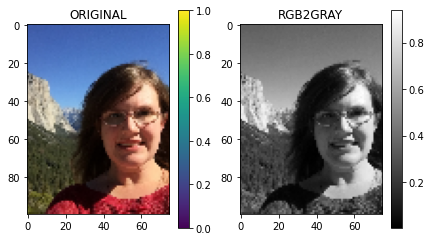

In [9]:
plt.figure(figsize=(7,4))

plt.subplot(121)
plt.title('ORIGINAL')
plt.imshow(train_images[0])
plt.colorbar()


plt.subplot(122)
plt.title('RGB2GRAY')
plt.imshow(color.rgb2gray(train_images[0]), cmap='gray')
plt.colorbar()
plt.show()

In [10]:
train_gray_images = np.array([color.rgb2gray(img).reshape((100,75,1)) for img in train_images])
test_gray_images = np.array([color.rgb2gray(img).reshape((100,75,1)) for img in test_images])

print(train_gray_images.shape)
print(test_gray_images.shape)

(1700, 100, 75, 1)
(300, 100, 75, 1)


## Modeling

In [11]:
from keras.layers import Dense, Input, Conv2D, Conv2DTranspose, Flatten, Reshape, MaxPool2D
from keras.layers import BatchNormalization, Dropout, Activation, concatenate
from keras.models import Model

In [12]:
def conv2d_block(x , channel) :
    x = Conv2D(channel, 3 , padding = 'same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(channel, 3 , padding = 'same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    return x

def unet_black() :
    inputs = Input((100,75,3))

    c1 = conv2d_block(inputs, 16)
    p1 = MaxPool2D(2)(c1)
    p1 = Dropout(0.1)(p1)

    c2 = conv2d_block(p1, 32)
    p2 = MaxPool2D(2)(c2)
    p2 = Dropout(0.1)(p2)

    c3 = conv2d_block(p2, 64)
    p3 = MaxPool2D(2)(c3)
    p3 = Dropout(0.1)(p3)

    c4 = conv2d_block(p3, 128)
    p4 = MaxPool2D(2)(c4)
    p4 = Dropout(0.1)(p4)

    c5 = conv2d_block(p4, 256)

    u6 = Conv2DTranspose(128, 2, 2, padding= 'valid', output_padding=(0,1))(c5)
    u6 = concatenate([u6,c4])
    u6 = Dropout(0.1)(u6)
    c6 = conv2d_block(u6, 128)

    u7 = Conv2DTranspose(64, 2, 2, padding= 'valid', output_padding=(1,0))(c6)
    u7 = concatenate([u7,c3])
    u7 = Dropout(0.1)(u7)
    c7 = conv2d_block(u7, 64)

    u8 = Conv2DTranspose(32, 2, 2, padding= 'valid', output_padding=(0,1))(c7)
    u8 = concatenate([u8,c2])
    u8 = Dropout(0.1)(u8)
    c8 = conv2d_block(u8, 32)

    u9 = Conv2DTranspose(16, 2, 2, padding= 'valid', output_padding=(0,1))(c8)
    u9 = concatenate([u9,c1])
    u9 = Dropout(0.1)(u9)
    c9 = conv2d_block(u9, 16)

    outputs = Conv2D(1,1, activation='sigmoid')(c9)

    model = Model(inputs, outputs)
    return model

In [13]:
model = unet_black()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 75, 3)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 100, 75, 16)  448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 100, 75, 16)  64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 100, 75, 16)  0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [14]:
model.compile(
    loss = 'mse',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [15]:
hist = model.fit(train_images, train_gray_images,
                 validation_data = (test_images, test_gray_images),
                 epochs = 10,
                 verbose = 1
)


Epoch 1/10
54/54 [==============================] - 38s 93ms/step - loss: 0.0369 - accuracy: 0.0101 - val_loss: 0.0614 - val_accuracy: 0.0177
Epoch 2/10
54/54 [==============================] - 4s 69ms/step - loss: 0.0063 - accuracy: 0.0124 - val_loss: 0.0505 - val_accuracy: 0.0181
Epoch 3/10
54/54 [==============================] - 4s 69ms/step - loss: 0.0038 - accuracy: 0.0136 - val_loss: 0.0413 - val_accuracy: 0.0181
Epoch 4/10
54/54 [==============================] - 4s 69ms/step - loss: 0.0027 - accuracy: 0.0123 - val_loss: 0.0309 - val_accuracy: 0.0181
Epoch 5/10
54/54 [==============================] - 4s 69ms/step - loss: 0.0019 - accuracy: 0.0122 - val_loss: 0.0202 - val_accuracy: 0.0181
Epoch 6/10
54/54 [==============================] - 4s 69ms/step - loss: 0.0023 - accuracy: 0.0106 - val_loss: 0.0128 - val_accuracy: 0.0181
Epoch 7/10
54/54 [==============================] - 4s 69ms/step - loss: 0.0015 - accuracy: 0.0104 - val_loss: 0.0058 - val_accuracy: 0.0181
Epoch 8/10
5

## Result


In [ ]:
res = model.predict()

## Pre-processing

## Pre-processing